# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression
import warnings
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [2]:
df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']

In [3]:
df

Value
date                
1993-01     702157.6
1993-02    2726925.3
1993-03    4730318.6
1993-04    7378367.8
1993-05   11680753.4
...              ...
1998-08  150639332.7
1998-09  148297693.4
1998-10  151889623.6
1998-11  148842093.6
1998-12  171697093.7

[72 rows x 1 columns]

## Step 1 : Making the data stationary

### Different techniques can be used to make the data stationary, taking natural log and differencing.

### Here we look at different stages of differencing the original data, but first, we need to check if the data is stationary or non stationary



### Augmented Dicky Fuller check function - To check for stationarity of data

### The p-value returned by the ADF test should be less than 0.05 for the data to be stationary.

In [4]:
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.108053645228377
p-value : 0.7118495413174986


<Axes: xlabel='date'>

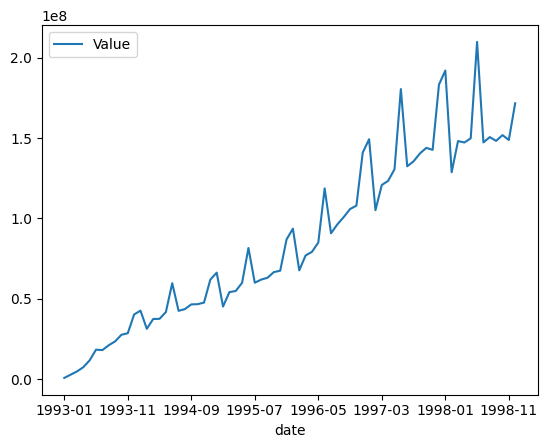

In [5]:
adf_check(df.Value.dropna())
new_df=pd.DataFrame(df.Value.dropna())
new_df.plot()

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.9697363545214809
p-value : 0.7641416500288277


<Axes: xlabel='date'>

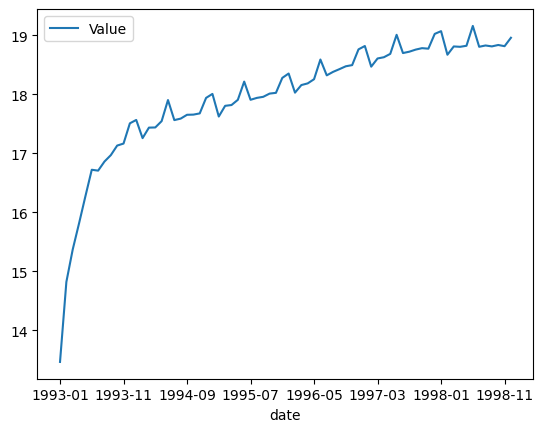

In [6]:
adf_check(np.log(df.Value).dropna())
new_df=pd.DataFrame(np.log(df.Value).dropna())
new_df.plot()

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.2814795547740216
p-value : 0.637602275038625


<Axes: xlabel='date'>

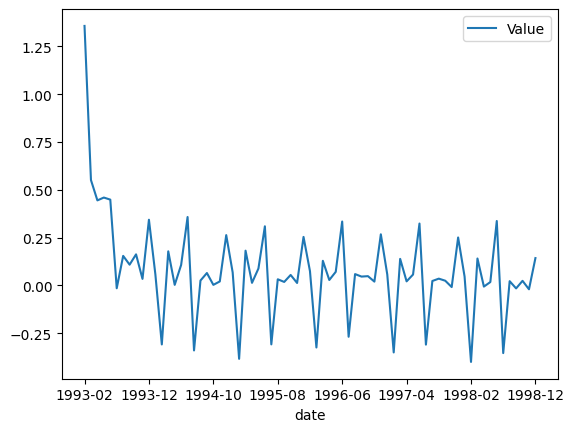

In [7]:
adf_check(np.log(df.Value).diff().dropna())
new_df=pd.DataFrame(np.log(df.Value).diff().dropna())
new_df.plot()

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609713749
p-value : 7.807176920147276e-06


<Axes: xlabel='date'>

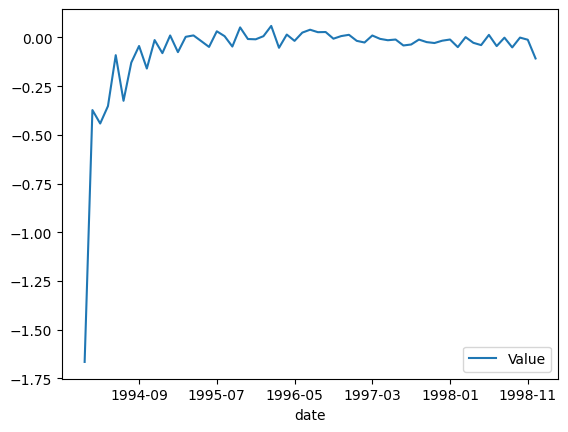

In [8]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
backup_df_tesing=df_testing.dropna().copy()
adf_check(df_testing.Value.dropna())
df_testing.plot()

### We plot the ACF and PACF plots for our differenced data.

### We get the values of p and q from PACF and ACF plots respectively.

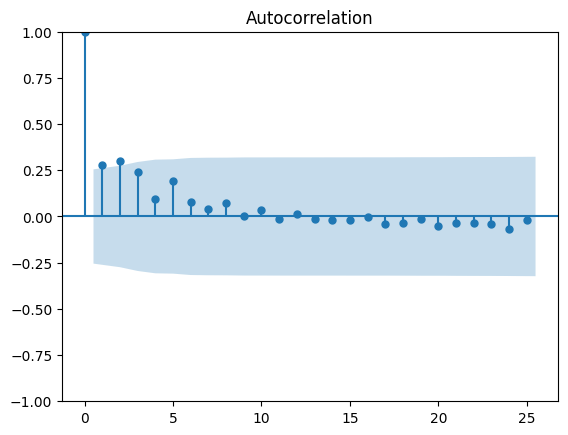

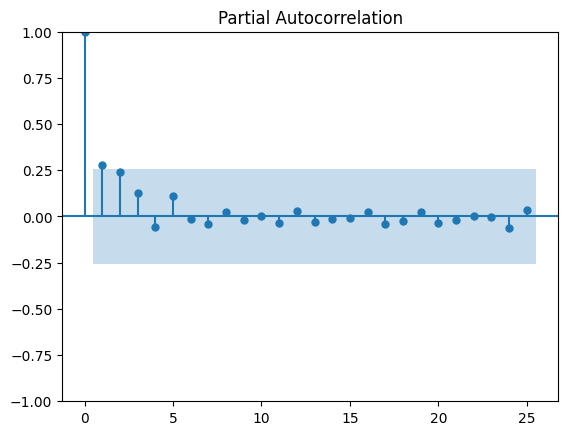

In [9]:
ACF = plot_acf(df_testing.dropna(),lags=25)
PACF = plot_pacf(df_testing.dropna(),lags=25)

## Step 2 : Fitting AR Model

### In the AR function, we perform linear regression on the previous values of the current timestep.

### We take p values before the current value, and perform linear regression on it

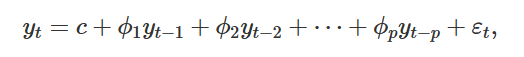

### AR Function

In [10]:
lr_ar = LinearRegression()

def AR(p,df):
  df_temp = df

  # Shifted the data to get previous p timestamp values

  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.9 * df_temp.shape[0]) - 1

  # Splitting into train and test data

  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  # Reshaping to convert it into a format where p previous values are in a list

  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  # Performing Linear Regression to find coefficients

  lr_ar.fit(X_train,y_train)

  theta  = lr_ar.coef_.T
  intercept = lr_ar.intercept_
  # Predicting the values using the coefficients generated through Linear Regression
  # for both Train and Test Datasets

  df_train_2['Predicted_Values'] = X_train.dot(lr_ar.coef_.T) + lr_ar.intercept_

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test["Predicted_Values"] = df_test["Value"]

  return [df_train_2,df_test,theta,intercept]

### We perform Auto Regression on the dataset by taking the value of p as m. This hypothesis was put forward in the Hannan–Rissanen Algorithm. The Hannan-Rissanen algorithm often involves testing and considering higher orders to capture potentially more intricate patterns or dependencies within the data.

In [11]:
[df_train,df_test,theta,intercept] = AR(5,pd.DataFrame(df_testing.Value))

In [12]:
df_c = pd.concat([df_train,df_test])

### We get the residuals for the given value of p, which are later used in integrating MA and getting test set predictions

In [13]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

<Axes: ylabel='Density'>

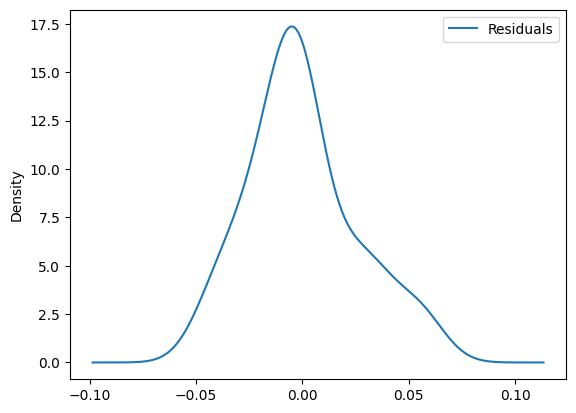

In [14]:
res.plot(kind='kde')

## Step 3 : Integrating MA

### The MA model uses the past forecast errors in a regression like model.

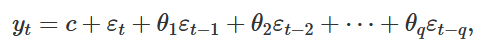

### We use the below equation for the next function, where previous values as well as previous errors are concatenated and regressed.

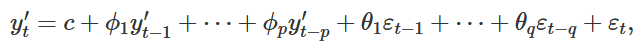

In [15]:
lr_final = LinearRegression()

def AR_MA_Integration(p, q, res, df):

    # Shifting the data to get past p input values and past q residual values

    df_temp = df.dropna()
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)
    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.9 * res.shape[0]) - 1

    # Splitting the input data and residuals into train and test sets

    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])
    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    # Cleaning the DataFrames by removing NaN values

    res_train_2 = res_train.dropna().copy()
    df_train_2 = df_train.dropna().copy()
    res_test_2 = res_test.dropna().copy()
    df_test_2 = df_test.dropna().copy()

    # Calculating difference to take relevant previous values for prediction
    # This is done to make sure that correct past values are taken.

    minus_tr=len(df_train_2)-len(res_train_2)
    minus_ts=len(df_test_2)-len(res_test_2)

    # Creating a combined X and Y, having last p input values and last q residual values

    combined_x=[]
    for i in range(min(len(res_train_2), len(df_train_2))):
        a,b=res_train_2.values[i][1:].tolist(),df_train_2.values[i+minus_tr][1:].tolist()
        combined_x.append(a+b)
    combined_x=np.array(combined_x)

    combined_y=[]
    for i in range(min(len(res_train_2), len(df_train_2))):
        a,b=res_train_2.values[i][0].tolist(),df_train_2.values[i+minus_tr][0]
        combined_y.append(a+b)
    combined_y=np.array(combined_y)

    # Performing Linear regression on the concatenated inputs

    lr_final.fit(combined_x, combined_y)

    # Generating intercepts and coefficients to be used

    theta = lr_final.coef_.T
    intercept = lr_final.intercept_

    # Combining the Test dataset for last p input values and q residuals

    combined_x_test=[]
    for i in range(len(res_test_2)):
        a,b=res_test_2.values[i][1:].tolist(),df_test_2.values[i+minus_ts][1:].tolist()
        combined_x_test.append(a+b)
    combined_x_test=np.array(combined_x_test)

    # Calculating the predictions on the test set by multiplying the values and the regression coefficients

    res_test['Predicted_Values'] = combined_x_test.dot(lr_final.coef_.T)  + lr_final.intercept_

    # Calculating RMSE on the predictions

    RMSE = np.sqrt(mean_squared_error(df_test[-(len(res_test)):]['Value'], res_test['Predicted_Values']))

    print("The RMSE is:", RMSE)
    return [res_train_2, res_test, theta, intercept, RMSE]

In [16]:
[res_train,res_test,theta,intercept,RMSE] = AR_MA_Integration(2, 3, pd.DataFrame(res.Residuals), pd.DataFrame(df_testing.Value))

The RMSE is: 0.043140974612371326


In [17]:
res_c = pd.concat([res_train,res_test])

### Predicted_Values and Residuals for dates used for prediction

In [18]:
res_c["Predicted_Values"][-7:]

date
1998-06   -0.020326
1998-07   -0.022723
1998-08   -0.001211
1998-09   -0.026263
1998-10   -0.008696
1998-11   -0.029539
1998-12   -0.005602
Name: Predicted_Values, dtype: float64

In [19]:
df_c.Predicted_Values = res_c.Predicted_Values

### Plotting the original values and predicted values

<Axes: xlabel='date'>

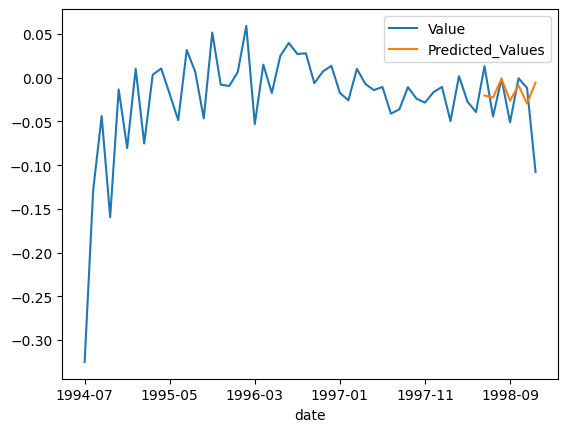

In [20]:
# This plot shows the input data plot in blue, and predicted data plot in orange
df_c[['Value','Predicted_Values']].plot()

### Magnified view

<Axes: xlabel='date'>

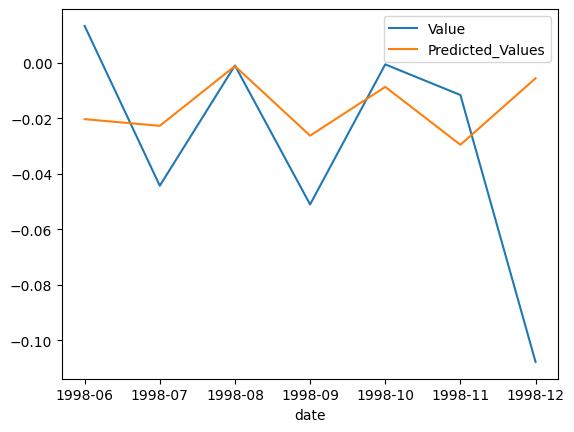

In [21]:
# A magnified view for the test set
df_c[['Value','Predicted_Values']][-7:].plot()

## Step 4 : Getting Back Original data

### Reversing the steps performed for differencing, as a check that the first column must be the same after reversing the steps.

In [22]:
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Value += np.log(df).shift(1).Value
df_c.Value = np.exp(df_c.Value)

df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

### Full data view

<Axes: xlabel='date'>

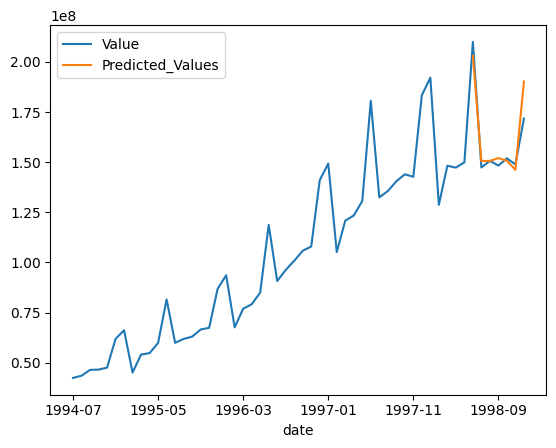

In [23]:
df_c.iloc[:,:][['Value','Predicted_Values']].plot()

### Magnified view

<Axes: xlabel='date'>

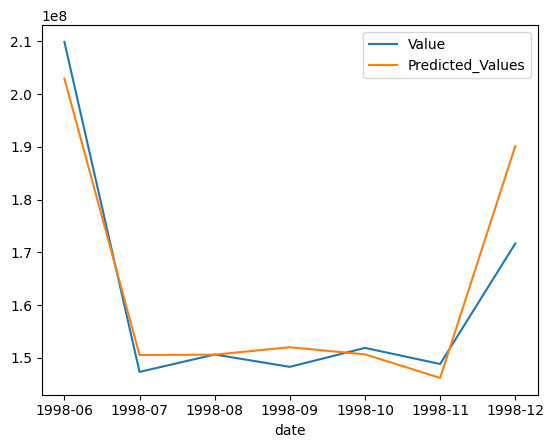

In [24]:
df_c.iloc[-7:,:][['Value','Predicted_Values']].plot()